# Darik's School to Code Good

Imports & Initialization

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from scratch import simulate_calcium_data, plot_data
from IPython.display import Image
from IPython.core.display import HTML 

In [2]:
Image(url= "https://github.com/darikoneil/dariks_school_to_code_good/blob/dev/logo.png")

**Why bother?**
- You don't want to struggle running a script named `decode_final_v2` 6 months from now
- You don't want to worry that modifying a function will break everything
- You don't want your colleagues to hate you when they do a code review
- You want to hand someone a script and not have to explain what it does
- You want to be confident in your code, especially when publishing
- You want to be efficient & productive: *good code works*

# Part I: Core Concepts
First, we'll look at how to *think* about code so that it's designed to be *used* and not to *work*  <br>
1. **The Art of Naming** - How to write *self-documenting* code <br>
2. **Modularity** - Building with bricks, not blobs <br>
3. **KISS** - Keep It Simple, Stupid! <br>
4. **Noiseless Documentation** - Documentation $\neq$ Comments <br>
5. **Error Handling & Validation** - Errors are *announced*, not corrected <br>
6. **The Principle of Least Astonishment** - Be obvious, consistent, and *predictable* <br>

## 1. The Art of Naming
*"Code is read much more often than it is written"* <br>
Let's image we have a dataset in which we record the calcium activity of 5 **neurons** over 30 **seconds** with a **frame rate** of 30 Hz.

In [3]:
data = simulate_calcium_data(5)

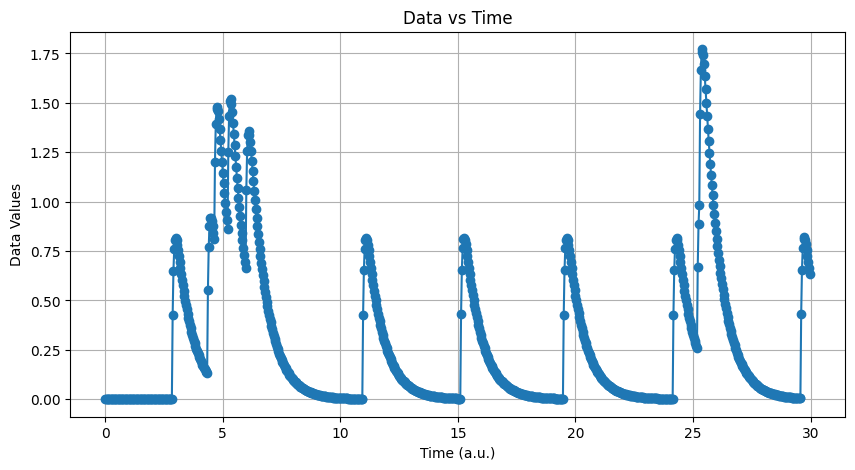

In [4]:
plot_data(data[:, 0], data[:, 1])

# Part II: Modern Tooling
1. **Your IDE & U** - Integrated Development Environments
2. **Virtual Environments & Dependency Management** -
3. **Testing & Code-Coverage** -
4. **Linting** -
5. **Formatting** -
6. **Validation** -
7. **Navigable Documentation**

## 1. Code is read more than it is written

In [ ]:
Imagine we have a dataset containing the 

In [ ]:
#### Bad 

In [ ]:
def mp(x, y)

#### ✅ BEST: Clearer naming and intent

In [ ]:
def mean_positive(values: list[float]) -> float:
    """Compute the mean of strictly positive values in a list."""
    positive_values = [v for v in values if v > 0]
    return stats.fmean(positive_values)